# Part 2: Stock price prediction

In [1]:
import os
import shutil

folder = './model'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [2]:
import pandas as pd
# FinBERT, truncation
# daily_data_merged = pd.read_csv('./data/dataset_FinBERT.csv', index_col=0)
    
# FinBERT, sliding window
# daily_data_merged = pd.read_csv('./data/dataset_FinBERT_sliding_window.csv', index_col=0)

# VADER
daily_data_merged = pd.read_csv('./data/dataset_VADER.csv', index_col=0)

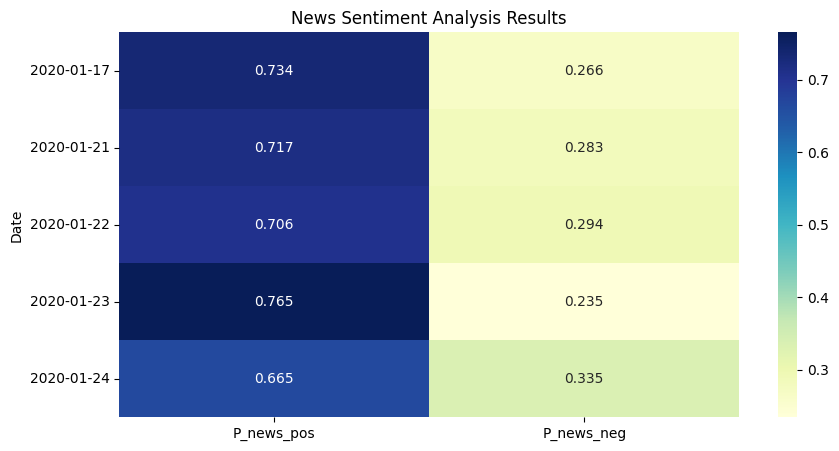

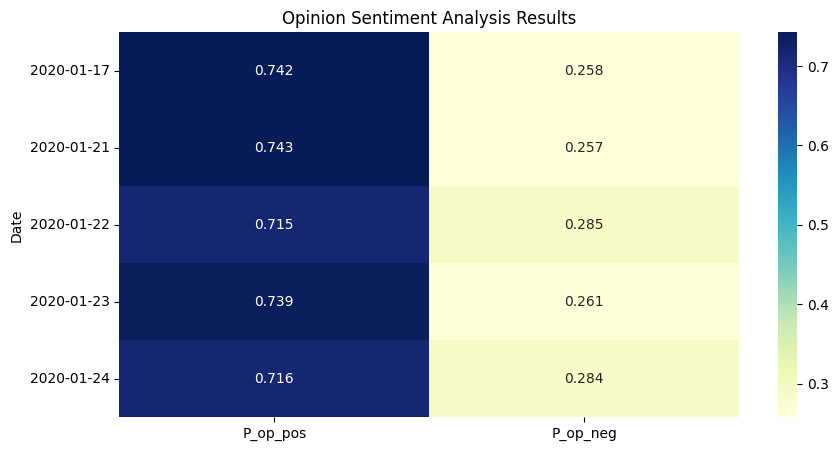

In [3]:
daily_sentiment_results = daily_data_merged[['Date', 'P_news_pos', 'P_news_neg', 'P_op_pos', 'P_op_neg']]
import seaborn as sns
import matplotlib.pyplot as plt

# Split the data into two parts: news sentiment analysis results and opinion sentiment analysis results
news_sentiment_results = daily_sentiment_results[['Date', 'P_news_pos', 'P_news_neg']]
opinion_sentiment_results = daily_sentiment_results[['Date', 'P_op_pos', 'P_op_neg']]

# Ensure 'Date' is in news_sentiment_results and opinion_sentiment_results
assert 'Date' in news_sentiment_results.columns
assert 'Date' in opinion_sentiment_results.columns

# Set 'Date' column as index
news_sentiment_results.set_index('Date', inplace=True)
opinion_sentiment_results.set_index('Date', inplace=True)

# Draw a heatmap for news sentiment analysis results
plt.figure(figsize=(10, 5))
plt.title('News Sentiment Analysis Results')
sns.heatmap(news_sentiment_results.tail(5), annot=True, cmap='YlGnBu', fmt=".3f")
plt.show()

# Draw a heatmap for opinion sentiment analysis results
plt.figure(figsize=(10, 5))
plt.title('Opinion Sentiment Analysis Results')
sns.heatmap(opinion_sentiment_results.tail(5), annot=True, cmap='YlGnBu', fmt=".3f")
plt.show()


In [4]:
# 选择特征和目标
# 保留原本的index，将'Date'列单独提取出来保存
date = daily_data_merged['Date']
date = pd.to_datetime(date)

features = daily_data_merged.drop(['Date'], axis=1)
# Open作为预测目标
target = daily_data_merged['Open']
features.tail()

,Open,High,Low,Close,Adj Close,Volume,P_news_neg,P_news_pos,P_op_neg,P_op_pos
1884,79.067497,79.684998,78.750000,79.682503,77.629234,137816400,0.265684,0.734316,0.257736,0.742264
1885,79.297501,79.754997,79.000000,79.142502,77.103172,110843200,0.282513,0.717487,0.257449,0.742551
1886,79.644997,79.997498,79.327499,79.425003,77.378380,101832400,0.294228,0.705772,0.284595,0.715405
1887,79.480003,79.889999,78.912498,79.807503,77.751030,104472000,0.234530,0.765470,0.260750,0.739250
1888,80.062500,80.832497,79.379997,79.577499,77.526955,146537600,0.334716,0.665284,0.284331,0.715669


In [5]:
features.head()

,Open,High,Low,Close,Adj Close,Volume,P_news_neg,P_news_pos,P_op_neg,P_op_pos
0,21.228571,21.639286,20.989643,21.565357,18.280512,487975600,0.329094,0.670906,0.329094,0.670906
1,21.692142,21.774286,21.375357,21.461430,18.192419,565132400,0.406780,0.593220,0.406780,0.593220
2,20.516430,20.742857,20.357143,20.534643,17.406801,877312800,0.000000,0.000000,0.000000,0.000000
3,20.705713,20.728571,20.370001,20.531429,17.404078,406632800,0.000000,0.000000,0.000000,0.000000
4,20.536072,20.922501,20.413929,20.898571,17.715296,403936400,0.396985,0.603015,0.396985,0.603015


In [6]:
target.tail()

1884    79.067497
1885    79.297501
1886    79.644997
1887    79.480003
1888    80.062500
Name: Open, dtype: float64

In [7]:
# normalization
from sklearn.preprocessing import MinMaxScaler

# Apply the MinMaxScaler to the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# fit_transform根据数据计算缩放参数
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# 保存缩放参数
import joblib
joblib.dump(scaler_features, './model/scaler_features.pkl')
joblib.dump(scaler_target, './model/scaler_target.pkl')

# Create new DataFrames with the scaled features and target
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_target_df = pd.DataFrame(scaled_target, columns=['Open'])

In [8]:
scaled_features.shape

(1889, 10)

In [9]:
scaled_target.shape

(1889, 1)

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

In [11]:
def create_sequences(features, targets, seq_length):
    """
    Create sequences of specified length from time series data.

    Args:
    features (np.array): The feature data.
    targets (np.array): The target data.
    seq_length (int): The length of the sequence.

    Returns:
    np.array: Sequences of features.
    np.array: Corresponding targets for each sequence.
    """
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length)]
        y = targets[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [12]:
# sequence length
seq_length = 25

# Create sequences
features_seq, target_seq = create_sequences(scaled_features, scaled_target, seq_length)


In [13]:
train_features, test_features, train_target, test_target = train_test_split(
    features_seq, target_seq, test_size=0.2, random_state=42
)

val_features, test_features, val_target, test_target = train_test_split(
    test_features, test_target, test_size=0.5, random_state=42
)

- 准备训练

In [14]:
# Convert sequences to Tensor
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)

val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

# 创建TensorDataset
train_dataset = TensorDataset(train_features, train_target)
val_dataset = TensorDataset(val_features, val_target)
test_dataset = TensorDataset(test_features, test_target)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
# 使用普通的LSTM模型，不使用注意力机制
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, output_dim, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # 打印lstm_out的形状
        # print(lstm_out.shape)
        # 取最后一个时间步的输出
        output = self.fc(lstm_out[:, -1, :])
        return output

In [16]:
# # 使用注意力机制的LSTM
# class Attention(nn.Module):
#     def __init__(self, hidden_size):
#         super(Attention, self).__init__()
#         self.hidden_size = hidden_size
#         self.attn = nn.Linear(self.hidden_size, 1)

#     def forward(self, hidden, encoder_outputs):
#         attn_weights = torch.tanh(self.attn(encoder_outputs))
#         return torch.bmm(attn_weights.transpose(1, 2), encoder_outputs).squeeze(1)

# class AttentionLSTM(nn.Module):
#     def __init__(self, input_dim, hidden_size, num_layers, output_dim, dropout=0.2):
#         super(AttentionLSTM, self).__init__()
#         self.hidden_size = hidden_size

#         # LSTM层
#         self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, 
#                             batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
#         # 注意力层
#         self.attention = Attention(hidden_size)
        
#         # 全连接层
#         self.fc = nn.Linear(hidden_size, output_dim)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         attn_out = self.attention(lstm_out[:, -1, :], lstm_out)
#         output = self.fc(attn_out)
#         return output

In [17]:
# 超参数
input_dim = scaled_features_df.shape[1]  # 特征数量
hidden_size = 100  # 隐藏状态中的特征数量，可以调整
num_layers = 4    # 堆叠的LSTM层的数量
output_dim = 1    # 输出维度的数量（预测一个值）

# 使用SimpleLSTM
model = SimpleLSTM(input_dim, hidden_size, num_layers, output_dim, dropout=0.2)
# 使用AttentionLSTM
# model = AttentionLSTM(input_dim, hidden_size, num_layers, output_dim, dropout=0.2)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Running on the GPU
best_model updated at epoch 1, best_val_loss : 0.0024
Epoch 1/50, Train Loss: 0.0181, Validation Loss: 0.0024
best_model updated at epoch 2, best_val_loss : 0.0006
best_model updated at epoch 5, best_val_loss : 0.0003
Epoch 6/50, Train Loss: 0.0006, Validation Loss: 0.0003
best_model updated at epoch 10, best_val_loss : 0.0002
Epoch 11/50, Train Loss: 0.0006, Validation Loss: 0.0006
best_model updated at epoch 13, best_val_loss : 0.0002
best_model updated at epoch 14, best_val_loss : 0.0002
Epoch 16/50, Train Loss: 0.0004, Validation Loss: 0.0006
best_model updated at epoch 17, best_val_loss : 0.0002
best_model updated at epoch 21, best_val_loss : 0.0002
Epoch 21/50, Train Loss: 0.0004, Validation Loss: 0.0002
best_model updated at epoch 22, best_val_loss : 0.0002
best_model updated at epoch 25, best_val_loss : 0.0001
Epoch 26/50, Train Loss: 0.0004, Validation Loss: 0.0001
best_model updated at epoch 27, best_val_loss : 0.0001
Epoch 31/50, Train Loss: 0.0003, Valida

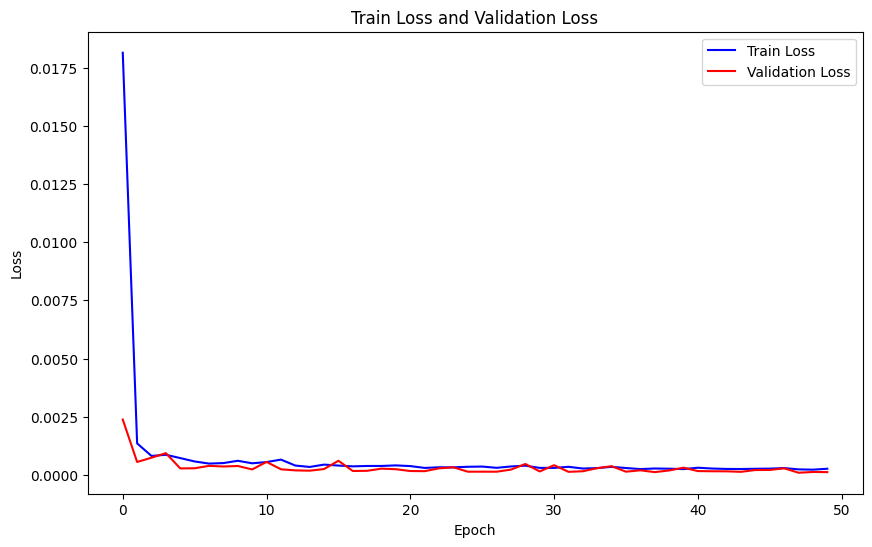

In [18]:
# 训练模型
num_epochs = 50
best_val_loss = float('inf')
train_loss_list = []
val_loss_list = []

# 检查是否有可用的GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # 如果有多个GPU，你可以通过改变这里的数字来选择特定的GPU
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

# 将模型移动到指定的设备
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        # 将数据移动到指定的设备
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            # 将数据移动到指定的设备
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './model/best_model.pth')
        print('best_model updated at epoch {}, best_val_loss : {:.4f}'.format(epoch+1, best_val_loss))
        
    # 每5轮打印一次train loss和val loss
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # 记录两个loss
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
# 在所有epochs结束后绘制损失图
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_loss_list, label='Train Loss', color='blue')
plt.plot(range(num_epochs), val_loss_list, label='Validation Loss', color='red')
plt.title('Train Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


The date range of the new test set is from 2019-09-12 00:00:00 to 2020-01-24 00:00:00
The length is 93


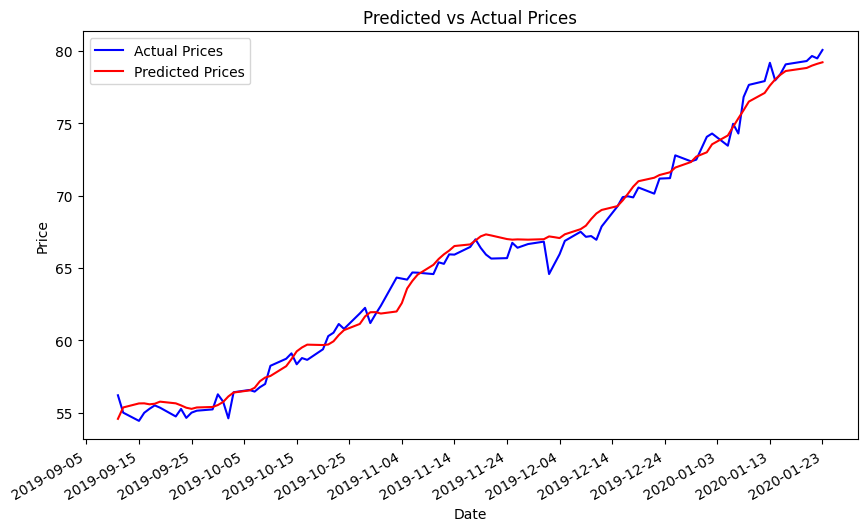

In [19]:
# 加载最佳模型
model.load_state_dict(torch.load('./model/best_model.pth'))

# 计算新的测试集的大小
test_size_new = int(len(features_seq) * 0.05)

# 按时间顺序划分新的测试集
test_features_new, test_target_new = features_seq[-test_size_new:], target_seq[-test_size_new:]

# 使用模型进行预测
model.eval()
with torch.no_grad():
    test_features_new = torch.tensor(test_features_new, dtype=torch.float32).to(device)
    test_predictions_new = model(test_features_new).cpu().numpy()

# 反缩放预测值
test_predictions_new = scaler_target.inverse_transform(test_predictions_new).flatten()

# 反缩放真实目标值
test_target_new = scaler_target.inverse_transform(test_target_new.reshape(-1, 1)).flatten()

# 计算日期的总长度
total_length = len(date)

# 计算测试集的开始位置
test_start = total_length - test_size_new

# 计算新的测试集的结束位置
test_end = total_length

# 获取新的测试集的日期范围
test_date_new = date[test_start:test_end]

# Print the date range of the new test set
print("The date range of the new test set is from", test_date_new.iloc[0], "to", test_date_new.iloc[-1])

# Print the length of the new test set
print("The length is", len(test_target_new))

# 绘制实际股价和预测股价的对比图
plt.figure(figsize=(10, 6))
plt.plot(date[test_start:], test_target_new, label='Actual Prices', color='blue')
plt.plot(date[test_start:], test_predictions_new, label='Predicted Prices', color='red')

# 设置x轴的日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # 设置日期间隔

plt.title('Predicted vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()  # 自动调整x轴日期标签的角度以提高可读性
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error

# 计算MSE
mse = mean_squared_error(test_target_new, test_predictions_new)
print('Test MSE: ', mse)
# 计算RMSE
rmse = np.sqrt(mse)
print('Test RMSE: ', rmse)

Test MSE:  0.7064075019183094
Test RMSE:  0.840480518464473
